In [ ]:
# @title Import libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, InputLayer, concatenate, Input, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Data Preprocessing

In [ ]:
# @title Read functions

# @markdown read_gov_data(URL_LINK)

# @markdown plot_gov_data(data, title)

# @markdown plot_correlation_matrix(data, columns, title)

# @markdown plot_seasonal_decomposition(data, target_column, title)

# @markdown find_date_range(datasets)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

def read_gov_data(URL_LINK):
  df = pd.read_parquet(URL_LINK)
  if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

  return df

def plot_gov_data(data, title):
  print(data.describe())
  print(data.head(5))

  plt.figure(figsize=(12, 6))
  for column in data.columns:
    if column == 'date':
      continue
    data[column].plot(label=column)

  plt.title('Time Series Plot of ' + title)
  plt.xlabel('Date')
  plt.legend()
  plt.show()

def plot_correlation_matrix(data, columns, title):
  correlation_matrix = data[columns].corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
  plt.title('Correlation Matrix')
  plt.show()

def plot_seasonal_decomposition(data, target_column, title):
  seasonal_decomposition = seasonal_decompose(data[target_column], model='additive', period=12)
  plt.figure(figsize=(12, 8))

  plt.subplot(2, 1, 1)
  plt.plot(data[target_column], label = title + " - Original")
  plt.plot(seasonal_decomposition.trend, label = title + " - Trend")

  plt.subplot(2, 1, 2)
  plt.plot(seasonal_decomposition.seasonal, label = title + " - Seasonal")
  plt.plot(seasonal_decomposition.resid, label = title + " - Residual")

  plt.legend()
  plt.title("Seaonsal Decomposition of " + title)
  plt.show()

def find_date_range(datasets):
    # Ensure that all datasets have a datetime index
    for df in datasets:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("All datasets must have a datetime index.")

    # Find the maximum start date
    max_start_date = max(df.index.min() for df in datasets)

    # Find the minimum end date
    min_end_date = min(df.index.max() for df in datasets)

    return max_start_date, min_end_date

In [ ]:
# @title Read data from data.gov.my
URL_ECON_INDICATOR = 'https://storage.dosm.gov.my/econindicators/economic_indicators.parquet'
URL_CPI = 'https://storage.dosm.gov.my/cpi/cpi_headline.parquet'
URL_IPI = 'https://storage.dosm.gov.my/ipi/ipi.parquet'
URL_PPI = 'https://storage.dosm.gov.my/ppi/ppi.parquet'
URL_LABOUR = 'https://storage.dosm.gov.my/labour/labourforce_monthly.parquet'

econ_indicator_df = read_gov_data(URL_ECON_INDICATOR)
cpi_df = read_gov_data(URL_CPI)
ipi_df = read_gov_data(URL_IPI)
ppi_df = read_gov_data(URL_PPI)
lfs_df = read_gov_data(URL_LABOUR)

In [ ]:
# @title Extract relevant data
start_date, end_date = find_date_range([econ_indicator_df, cpi_df, ppi_df, ipi_df])

def get_col_from(df, column):
  return df[column][(df.index >= start_date) & (df.index <= end_date)]

def read_data():
  data = pd.DataFrame()
  data["cpi_overall"] = get_col_from(cpi_df, "overall")

  data["ipi_overall"] = get_col_from(ipi_df, "overall")
  data["ipi_mfg"] = get_col_from(ipi_df, "mfg")
  data["ipi_elec"] = get_col_from(ipi_df, "electric")

  data["ppi_agri"] = get_col_from(ppi_df, "agriculture")
  data["ppi_mining"] = get_col_from(ppi_df, "mining")
  data["ppi_mfg"] = get_col_from(ppi_df, "manufacturing")
  data["ppi_elec"] = get_col_from(ppi_df, "electricity")
  data["ppi_water"] = get_col_from(ppi_df, "water")
  data["ppi_overall"] = get_col_from(ppi_df, "overall")

  data["labour_unemployed"] = get_col_from(lfs_df, "unemployed")
  data["labour_employed"] = get_col_from(lfs_df, "employed")

  data["cpi_trend"] = seasonal_decompose(data["cpi_overall"], model='additive', period=12).trend
  data['cpi_trend'].fillna(method='ffill', inplace=True)
  data['cpi_trend'].fillna(method='bfill', inplace=True)

  data["ipi_trend"] = seasonal_decompose(data["ipi_overall"], model='additive', period=12).trend
  data['ipi_trend'].fillna(method='ffill', inplace=True)
  data['ipi_trend'].fillna(method='bfill', inplace=True)

  data["ppi_trend"] = seasonal_decompose(data["ppi_overall"], model='additive', period=12).trend
  data['ppi_trend'].fillna(method='ffill', inplace=True)
  data['ppi_trend'].fillna(method='bfill', inplace=True)

  data["labour_unemployed_trend"] = seasonal_decompose(data["labour_unemployed"], model='additive', period=12).trend
  data['labour_unemployed_trend'].fillna(method='ffill', inplace=True)
  data['labour_unemployed_trend'].fillna(method='bfill', inplace=True)

  data["labour_employed_trend"] = seasonal_decompose(data["labour_employed"], model='additive', period=12).trend
  data['labour_employed_trend'].fillna(method='ffill', inplace=True)
  data['labour_employed_trend'].fillna(method='bfill', inplace=True)

  # data_size = len(data)
  # print("Number of data: " + str(data_size))

  # inflation_monthly = [0]
  # inflation_overall = [100]

  # for index in range(1, data_size):
  #   old_cpi = data["cpi_overall"][index - 1]
  #   new_cpi = data["cpi_overall"][index]

  #   inflation = ((new_cpi - old_cpi) / old_cpi) * 100
  #   inflation_monthly.append(inflation)

  #   previous_inflation = inflation_overall[-1]
  #   new_inflation = previous_inflation * (1 + inflation/100)

  #   inflation_overall.append(new_inflation)
  # data["inflation_monthly"] = inflation_monthly
  # data["inflation_overall"] = inflation_overall

  return data

data = read_data()
data

,cpi_overall,ipi_overall,ipi_mfg,ipi_elec,ppi_agri,ppi_mining,ppi_mfg,ppi_elec,ppi_water,ppi_overall,labour_unemployed,labour_employed,cpi_trend,ipi_trend,ppi_trend,labour_unemployed_trend,labour_employed_trend
date,,,,,,,,,,,,,,,,,
2015-01-01,110.6,101.028890,99.035338,98.012991,95.2,88.8,106.4,115.8,107.4,104.1,450.3,13991.8,112.970833,100.136122,102.016667,467.833333,14149.395833
2015-02-01,109.9,90.811590,89.004522,88.746098,95.0,96.5,106.2,116.1,103.8,104.6,461.8,14092.9,112.970833,100.136122,102.016667,467.833333,14149.395833
2015-03-01,110.9,101.660019,99.182022,104.108938,95.0,92.0,105.7,116.9,107.8,103.8,440.7,14160.5,112.970833,100.136122,102.016667,467.833333,14149.395833
2015-04-01,111.9,97.040950,97.006731,101.157770,92.0,98.2,104.4,114.3,108.0,103.1,433.3,14136.2,112.970833,100.136122,102.016667,467.833333,14149.395833
2015-05-01,112.3,100.677058,99.450914,102.587036,91.4,94.7,103.0,115.0,109.1,101.6,448.3,14126.7,112.970833,100.136122,102.016667,467.833333,14149.395833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,129.8,120.636660,132.436040,111.875699,121.7,97.1,120.7,118.0,117.7,118.4,591.9,16189.3,129.125000,127.171342,119.512500,599.545833,16132.779167
2023-03-01,129.9,130.643658,142.773621,127.168885,127.5,96.5,120.6,118.6,117.4,118.7,588.7,16223.0,129.125000,127.171342,119.512500,599.545833,16132.779167
2023-04-01,130.0,116.599065,126.483988,122.999116,128.5,97.0,120.7,117.9,117.4,118.9,586.9,16251.4,129.125000,127.171342,119.512500,599.545833,16132.779167


# Data Visualisation

          leading  coincident     lagging  leading_diffusion  \
count  390.000000  390.000000  390.000000         390.000000   
mean    85.735897   83.906667   80.482308          58.870000   
std     15.193600   19.913942   26.430758          23.844649   
min     56.500000   44.600000   40.000000           0.000000   
25%     73.025000   69.175000   59.175000          42.900000   
50%     87.300000   81.800000   75.850000          57.100000   
75%     99.300000   99.750000   99.600000          71.400000   
max    113.000000  124.300000  142.300000         100.000000   

       coincident_diffusion  
count            390.000000  
mean              73.673846  
std               27.366139  
min                0.000000  
25%               60.000000  
50%               83.300000  
75%              100.000000  
max              100.000000  
            leading  coincident  lagging  leading_diffusion  \
date                                                          
1991-01-01     56.6        

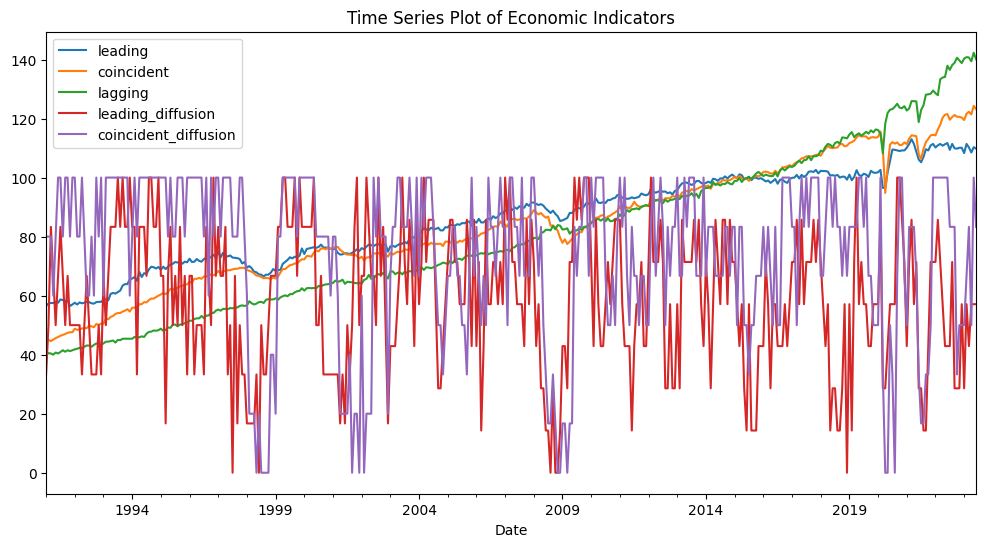

          overall  food_beverage  alcohol_tobacco  clothing_footwear  \
count  164.000000     164.000000       164.000000         164.000000   
mean   115.063415     123.879878       144.257927          96.901220   
std      8.806649      14.562251        28.424542           2.624962   
min     99.400000      99.000000        98.300000          93.000000   
25%    106.675000     111.100000       108.500000          93.600000   
50%    116.250000     124.800000       165.300000          98.300000   
75%    121.400000     134.125000       168.000000          98.900000   
max    130.800000     152.600000       171.100000         101.200000   

       housing_utilities  furnishings      health   transport  communication  \
count         164.000000   164.000000  164.000000  164.000000     164.000000   
mean          113.306098   111.673780  115.740244  109.944512      97.947561   
std             8.135024     7.384114    9.063090    7.059930       1.472048   
min            99.400000    99.

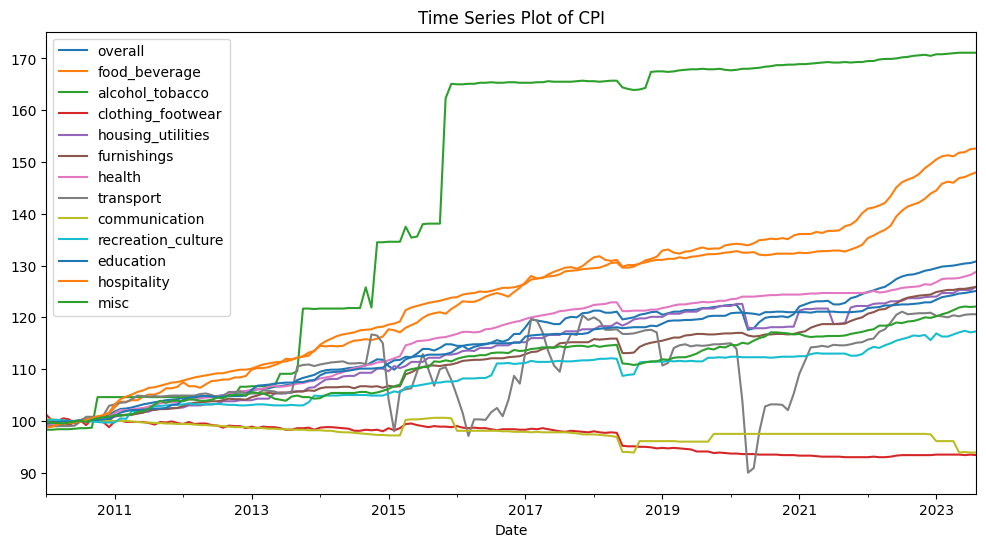

          overall      mining         mfg    electric    mfg_food  \
count  103.000000  103.000000  103.000000  103.000000  103.000000   
mean   112.699386   97.378540  118.161490  114.558697  115.794773   
std      9.933331    6.966048   14.369915    8.720210   12.015599   
min     77.004130   80.204696   73.110305   88.746098   80.899412   
25%    105.476105   92.525264  107.264276  109.007392  107.491627   
50%    113.215045   97.756373  118.705495  115.412000  117.212486   
75%    117.907076  103.268789  127.347622  121.037564  124.287815   
max    131.097460  111.824753  146.109927  134.433256  141.302274   

       mfg_textiles    mfg_wood  mfg_petroleum   mfg_metal  mfg_electric  \
count    103.000000  103.000000     103.000000  103.000000    103.000000   
mean     115.848245  115.447393     115.642337  110.032040    129.347021   
std       15.815695   14.508469      12.419597   12.440951     25.044507   
min       32.503288   37.109468      86.738704   43.902787     80.000671  

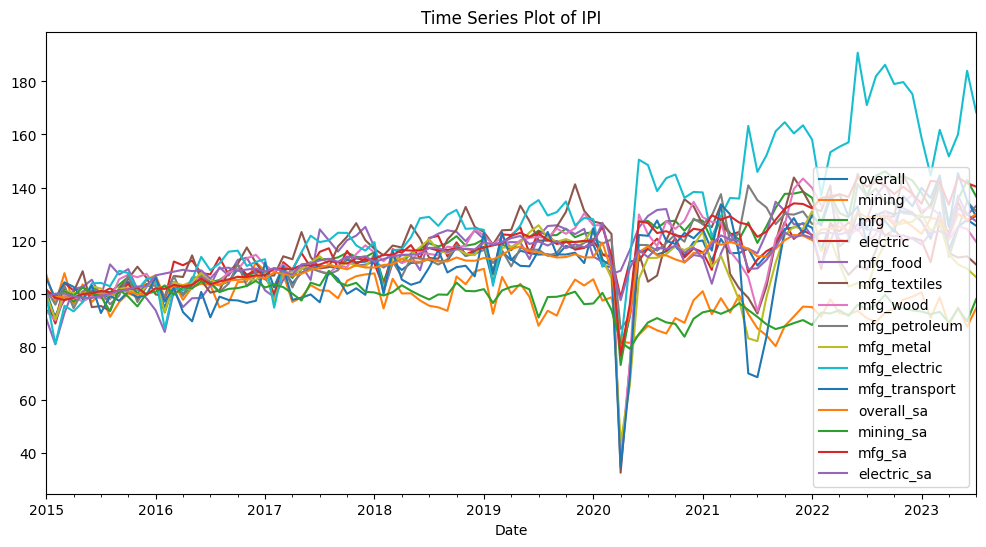

          overall  agriculture      mining  manufacturing  electricity  \
count  163.000000   163.000000  163.000000     163.000000   163.000000   
mean   108.290798   109.974233  105.311656     108.333129   112.794479   
std      6.223054    19.224976   25.699545       5.450168     5.954262   
min     98.400000    87.300000   44.700000      98.800000    99.400000   
25%    103.800000    94.800000   91.300000     105.700000   108.200000   
50%    107.600000   104.900000  100.300000     107.100000   115.000000   
75%    112.650000   120.750000  129.200000     109.800000   117.000000   
max    124.100000   178.700000  157.200000     122.800000   123.300000   

            water  
count  163.000000  
mean   110.077914  
std      4.965685  
min     99.100000  
25%    105.450000  
50%    111.800000  
75%    114.000000  
max    118.400000  
            overall  agriculture  mining  manufacturing  electricity  water
date                                                                       
2

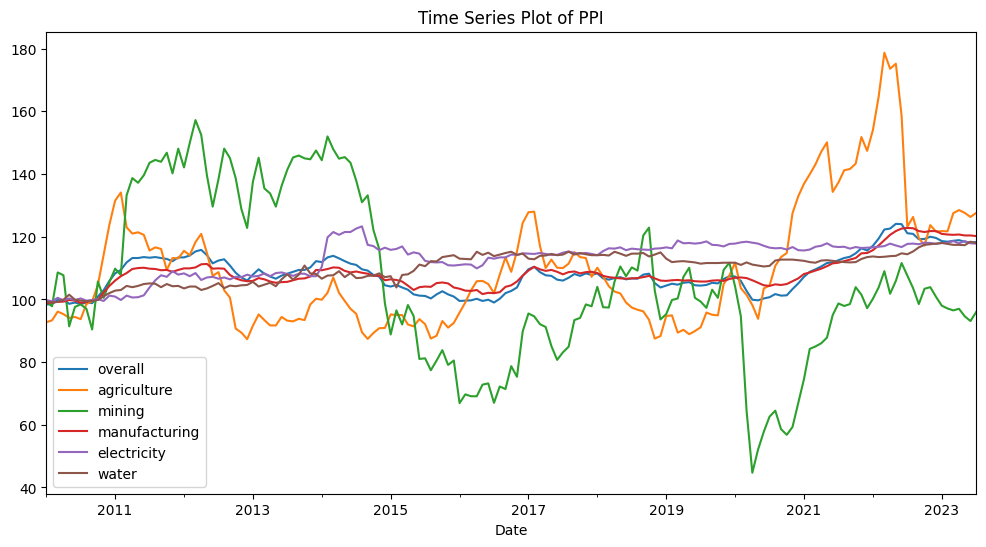

           lf_size      employed  unemployed      outside      u_rate  \
count    163.00000    163.000000  163.000000   163.000000  163.000000   
mean   14774.94673  14259.154037  515.793583  7084.343472    3.461263   
std     1289.96979   1201.717798  114.926929   190.974319    0.546845   
min    12059.80000  11632.300000  346.800000  6557.257000    2.630000   
25%    14002.43100  13560.992000  425.858000  6938.900000    3.130000   
50%    14788.90000  14276.700000  508.500000  7095.879000    3.340000   
75%    15810.76200  15194.600000  552.214000  7226.250000    3.500000   
max    16914.20000  16335.000000  826.100000  7475.400000    5.256666   

           p_rate    ep_ratio    lf_size_sa   employed_sa  unemployed_sa  ...  \
count  163.000000  163.000000    163.000000    163.000000     163.000000  ...   
mean    67.489559   65.148529  14774.538198  14259.111707     515.477673  ...   
std      1.721650    1.568634   1290.818024   1202.239523     114.813604  ...   
min     62.530000 

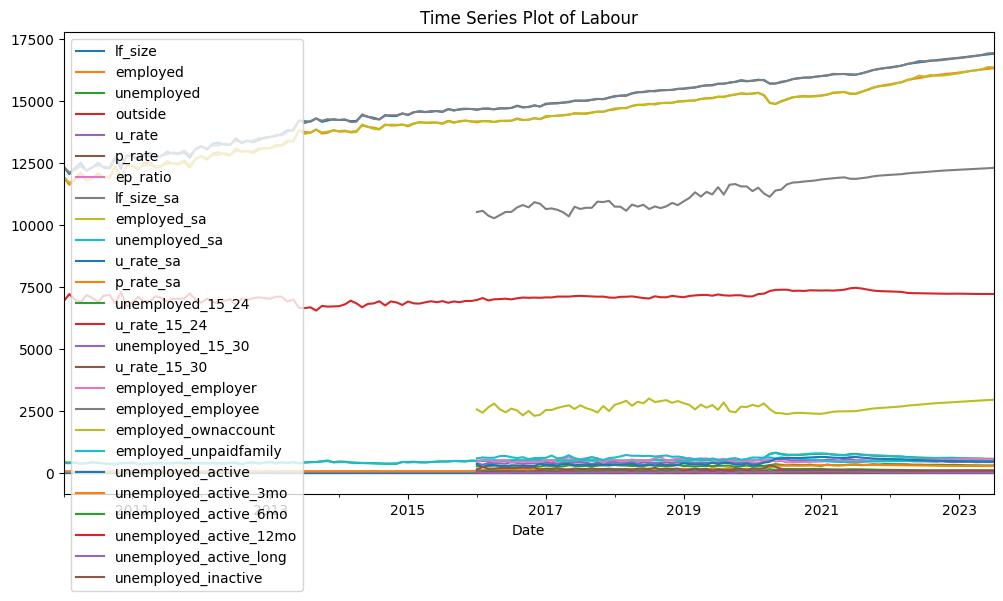

             overall_sales     wholesale_sales        retail_sales  \
count                 67.0                67.0                67.0   
mean   114053650933.462692  54160040107.686569  47134333524.686569   
std     14224784127.292908   4786973423.393452   6916639359.322681   
min          66851887335.0       37694128833.0       28319978255.0   
25%         106160659629.0       51473373190.0       42781884669.0   
50%         111094830591.0       53210237814.0       44843565760.0   
75%         122204348130.5       58082334835.0       49410430256.5   
max         139778613084.0       63093340298.0       60462438251.0   

              motor_sales  overall_index  wholesale_index  retail_index  \
count                67.0      67.000000        67.000000     67.000000   
mean   12759277316.820896     130.045294       127.170191    142.473916   
std     3364034433.479148      13.137883         8.058757     17.400554   
min           837780248.0      74.614590        88.473474     82.5923

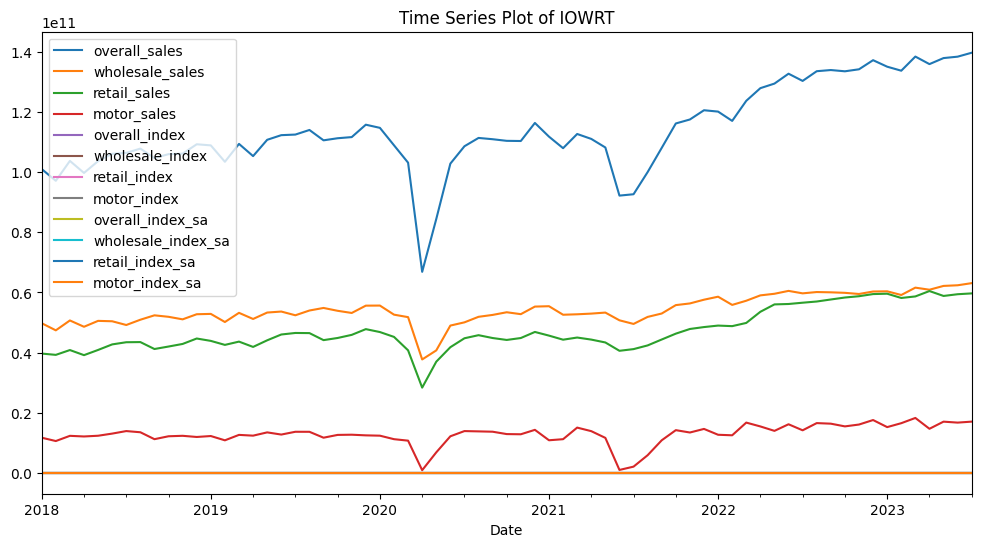

In [ ]:
# @title Visualise data distribution

plot_gov_data(econ_indicator_df, "Economic Indicators")
plot_gov_data(cpi_df, "CPI")
plot_gov_data(ipi_df, "IPI")
plot_gov_data(ppi_df, "PPI")
plot_gov_data(lfs_df, "Labour")

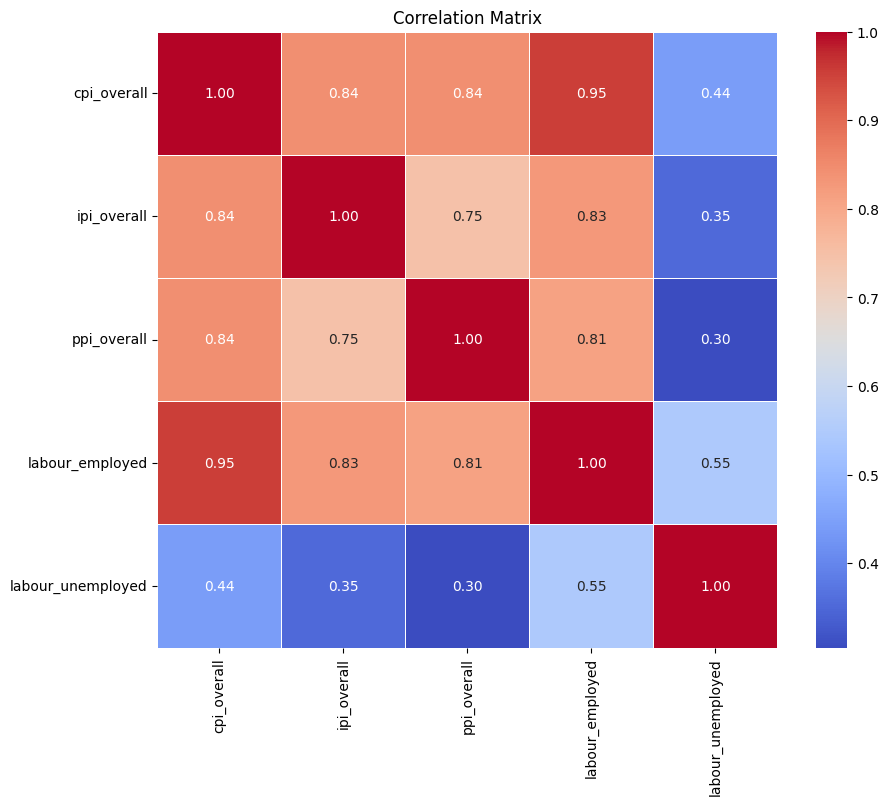

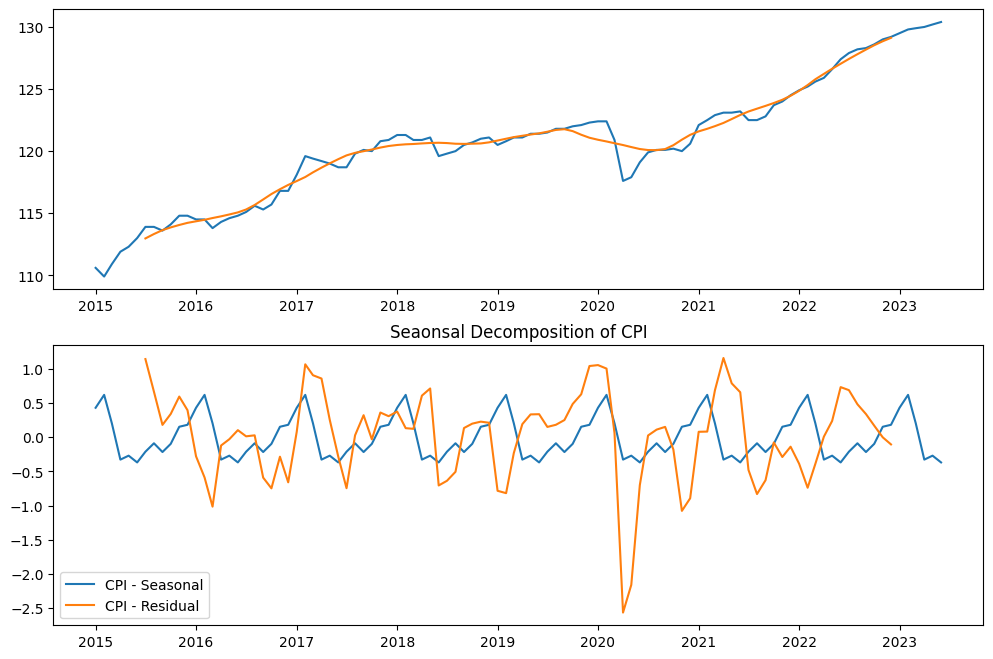

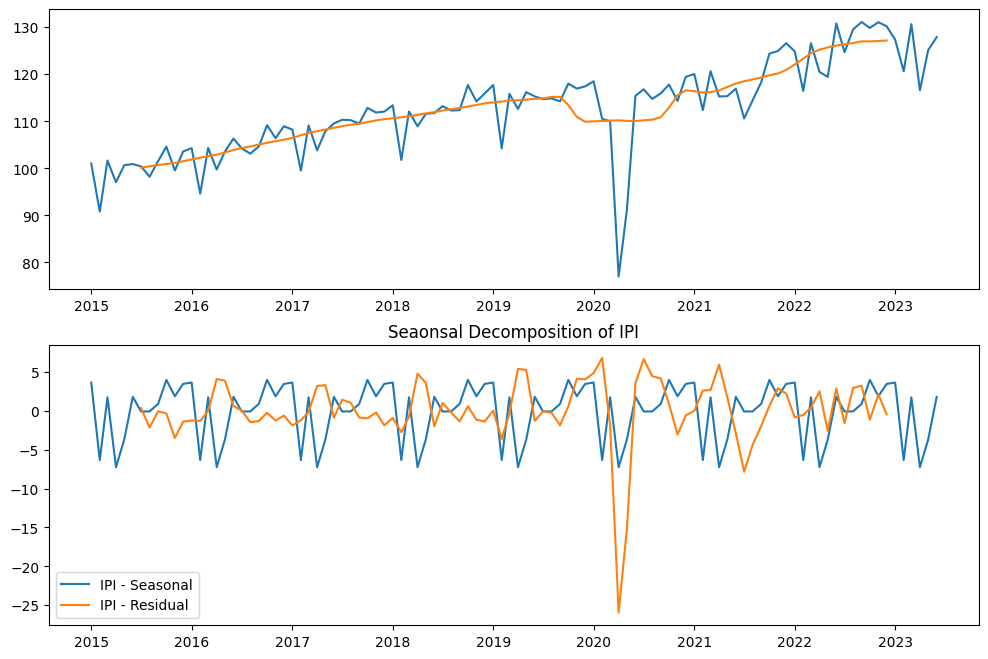

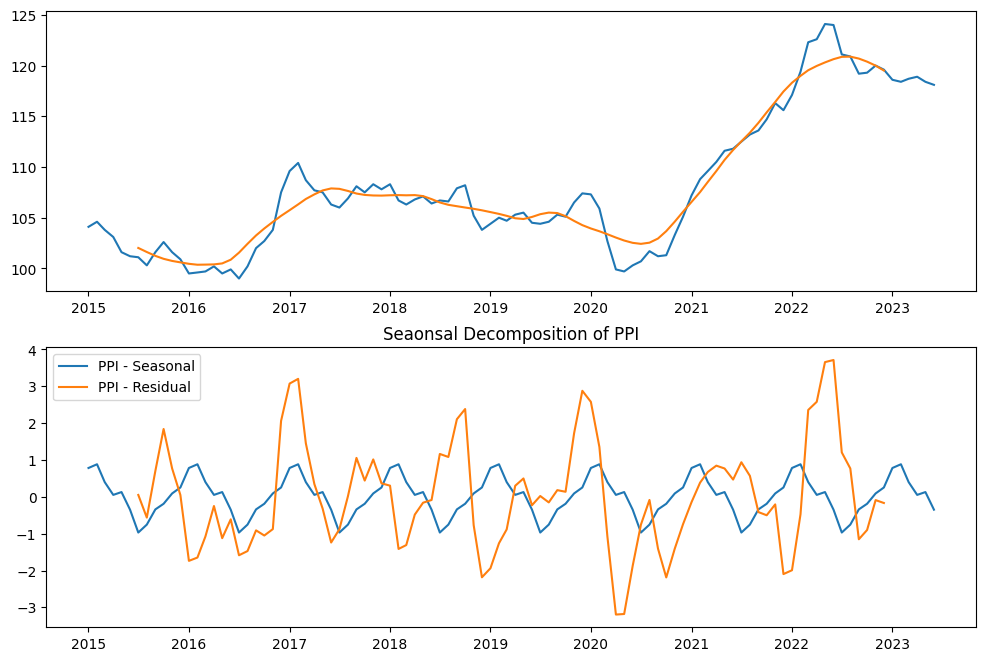

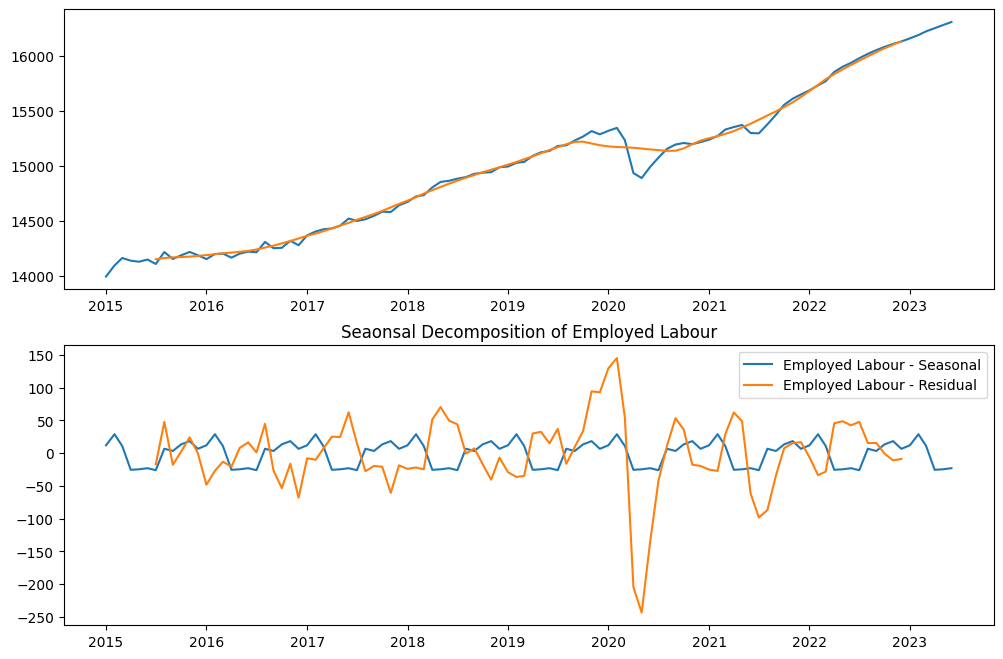

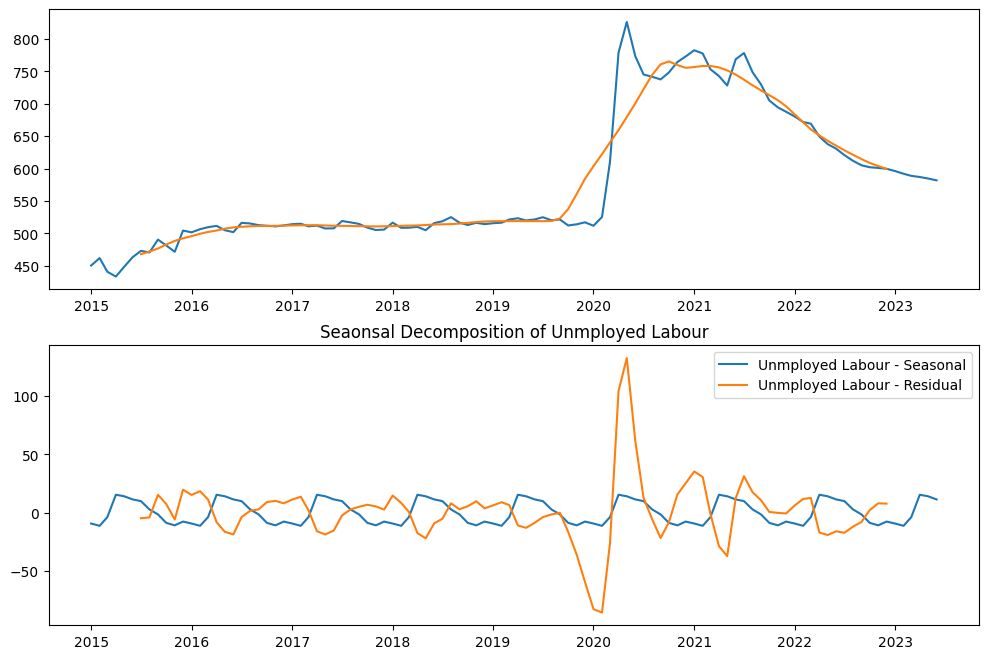

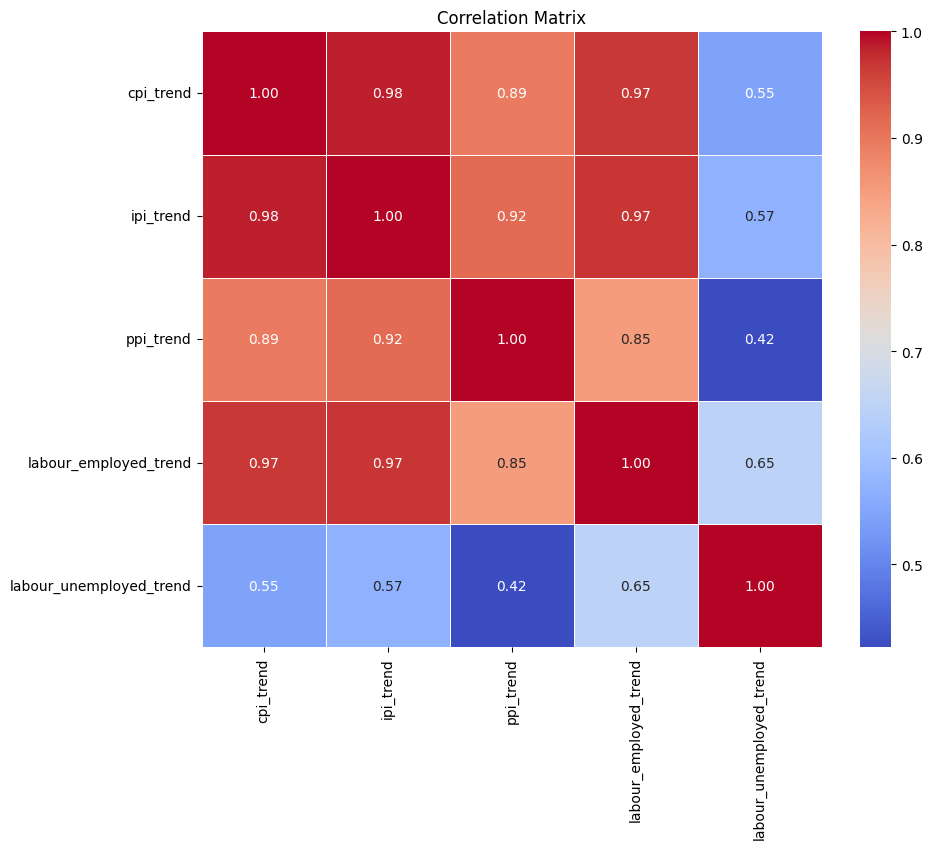

In [ ]:
columns = [
           'cpi_overall',
           'ipi_overall',
           'ppi_overall',
           'labour_employed',
           'labour_unemployed',
           ]
plot_correlation_matrix(data, columns, "Correlation Matrix")

plot_seasonal_decomposition(data, "cpi_overall", "CPI")
plot_seasonal_decomposition(data, "ipi_overall", "IPI")
plot_seasonal_decomposition(data, "ppi_overall", "PPI")
plot_seasonal_decomposition(data, "labour_employed", "Employed Labour")
plot_seasonal_decomposition(data, "labour_unemployed", "Unmployed Labour")

columns = [
           'cpi_trend',
           'ipi_trend',
           'ppi_trend',
           'labour_employed_trend',
           'labour_unemployed_trend',
           ]
plot_correlation_matrix(data, columns, "Correlation Matrix")


# Model Definition

In [ ]:
# @title Parameters for loading the data

train_ratio = 0.7 # @param {type:"number"}
val_ratio = 0.2 # @param {type:"number"}
test_ratio = 0.1 # @param {type:"number"}

data = read_data()

In [ ]:
# @title Model Callbacks
class IntervalLogger(tf.keras.callbacks.Callback):
  def __init__(self, interval):
    self.interval = interval

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.interval == 0:
      print(f'Epoch {epoch} - Loss: {logs["loss"]:.4f}, Val Loss: {logs["val_loss"]}')

class LogLossesToGraph(tf.keras.callbacks.Callback):
  def __init__(self):
    self.losses = []
    self.val_losses = []

  def on_epoch_end(self, epoch, logs=None):
    self.losses.append(logs["loss"])
    self.val_losses.append(logs["val_loss"])

  def show_losses(self):
    plt.figure(figsize=(12, 6))
    plt.plot(self.losses, label="loss")
    plt.plot(self.val_losses, label="val_loss")
    plt.legend()
    plt.title("Training and validation losses")
    plt.show()

class EarlyStopOnLossThreshold(EarlyStopping):
    def __init__(self, monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', threshold=0.1):
        super(EarlyStopOnLossThreshold, self).__init__(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose, mode=mode)
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)
        if current_loss is not None and current_loss < self.threshold:
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print(f"Training stopped at epoch {epoch + 1} because {self.monitor} reached the threshold of {self.threshold}.")

## Linear Regression

Mean Squared Error: 2.9395691623672895
Mean Absolute Error: 1.5207258882759942


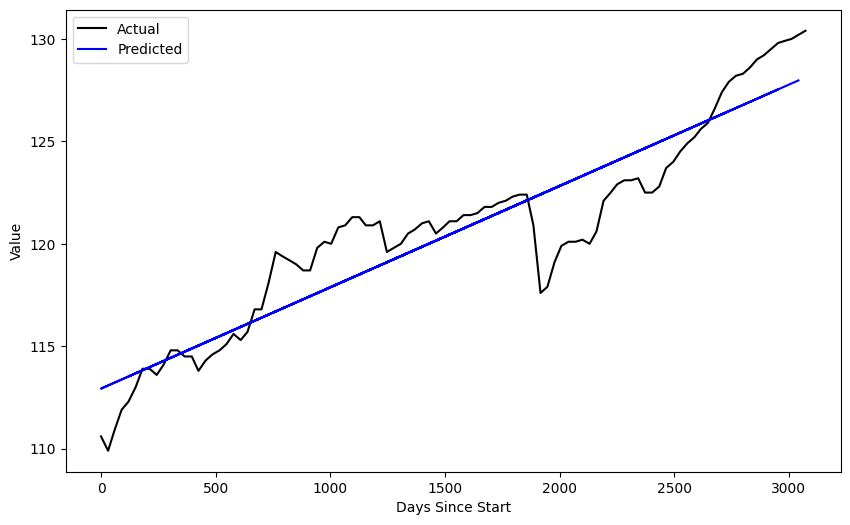

In [ ]:
# Extract X and y
data = read_data()
start_date = data.index.min()
data['days_since_start'] = (data.index - start_date).days

X = data["days_since_start"]
y = data["cpi_overall"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reshaped = X_train.values.reshape(-1, 1)
X_test_reshaped = X_test.values.reshape(-1, 1)

model = LinearRegression()
model.fit(X_train_reshaped, y_train)

y_pred = model.predict(X_test_reshaped)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

plt.figure(figsize=(10, 6))
plt.plot(X, y, color='black', label='Actual')
plt.plot(X_test, y_pred, color='blue', label='Predicted')
plt.xlabel('Days Since Start')
plt.ylabel('Value')
plt.legend()
plt.show()


## FCNN

In [ ]:
# @title Loading data for model

# input_columns =  [
#     'cpi_overall',
#     'ppi_overall',
#     'ipi_overall',
#     'labour_employed',
#     'labour_unemployed',
# ]
input_columns =  [
    'cpi_trend',
    'ppi_trend',
    'ipi_trend',
    'labour_employed_trend',
    'labour_unemployed_trend',
]
target_column = ['cpi_overall']
target_forecast_months = [3, 6, 9, 12]
max_forecast_months = max(target_forecast_months)

X, y = [], []
for i in range(len(data) - max_forecast_months):
  X.append(data[input_columns].iloc[i])
  y.append([ data[target_column].iloc[i+j][0] for j in target_forecast_months ])
X = np.array(X)
y = np.array(y)

train_size = int(len(X) * train_ratio)
val_size = int(len(X) * val_ratio)
test_size = int(len(X) * test_ratio)

val_size_cum = train_size + val_size
test_size_cum = len(X)

print("Train : " + str(train_size))
print("Val : " + str(val_size) + ", cumulative : " + str(val_size_cum))
print("Test : " + str(test_size) + ", cumulative : " + str(test_size_cum))

X_train_total, y_train_total = X[: val_size_cum], y[: val_size_cum]
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=val_ratio, random_state=42)
X_test, y_test = X[val_size_cum:], y[val_size_cum:]

scaler_x = StandardScaler()
X_train_total_scaled = scaler_x.fit_transform(X_train_total)
X_train_scaled = scaler_x.fit_transform(X_train)
X_val_scaled = scaler_x.transform(X_val)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()

y_train_total_scaled = scaler_y.fit_transform(y_train_total)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

input_shape = (X_train_scaled.shape[1], )
output_shape = len(target_forecast_months)

print("Train X shape : " + str(X_train_scaled.shape))
print("Train Y shape : " + str(y_train_scaled.shape))
print("Val X shape : " + str(X_val_scaled.shape))
print("Val Y shape : " + str(y_val_scaled.shape))
print("Test X shape : " + str(X_test_scaled.shape))
print("Test Y shape : " + str(y_test_scaled.shape))

Train : 62
Val : 18, cumulative : 80
Test : 9, cumulative : 90
Train X shape : (64, 5)
Train Y shape : (64, 4)
Val X shape : (16, 5)
Val Y shape : (16, 4)
Test X shape : (10, 5)
Test Y shape : (10, 4)


In [ ]:
# @title Model Parameters

training_epochs = 1200 # @param {type:"integer"}
training_log_interval = 25 # @param {type:"integer"}
early_stop_threshold = 0.01 # @param {type:"integer"} 0 = no early stopping.
learning_rate = 0.0002 # @param {type:"number"}

Epoch 0 - Loss: 1.1450, Val Loss: 1.1738946437835693
Epoch 25 - Loss: 0.7694, Val Loss: 0.8399389386177063
Epoch 50 - Loss: 0.5643, Val Loss: 0.6644678115844727
Epoch 75 - Loss: 0.4250, Val Loss: 0.5132968425750732
Epoch 100 - Loss: 0.3357, Val Loss: 0.40184465050697327
Epoch 125 - Loss: 0.2753, Val Loss: 0.3221537172794342
Epoch 150 - Loss: 0.2340, Val Loss: 0.2673262655735016
Epoch 175 - Loss: 0.1962, Val Loss: 0.2196076512336731
Epoch 200 - Loss: 0.1635, Val Loss: 0.17813879251480103
Epoch 225 - Loss: 0.1437, Val Loss: 0.15159516036510468
Epoch 250 - Loss: 0.1329, Val Loss: 0.13653609156608582
Epoch 275 - Loss: 0.1258, Val Loss: 0.12680348753929138
Epoch 300 - Loss: 0.1203, Val Loss: 0.11936267465353012
Epoch 325 - Loss: 0.1160, Val Loss: 0.11413000524044037
Epoch 350 - Loss: 0.1124, Val Loss: 0.11036878824234009
Epoch 375 - Loss: 0.1092, Val Loss: 0.1072295755147934
Epoch 400 - Loss: 0.1064, Val Loss: 0.10420951247215271
Epoch 425 - Loss: 0.1036, Val Loss: 0.10158728063106537
Epoch

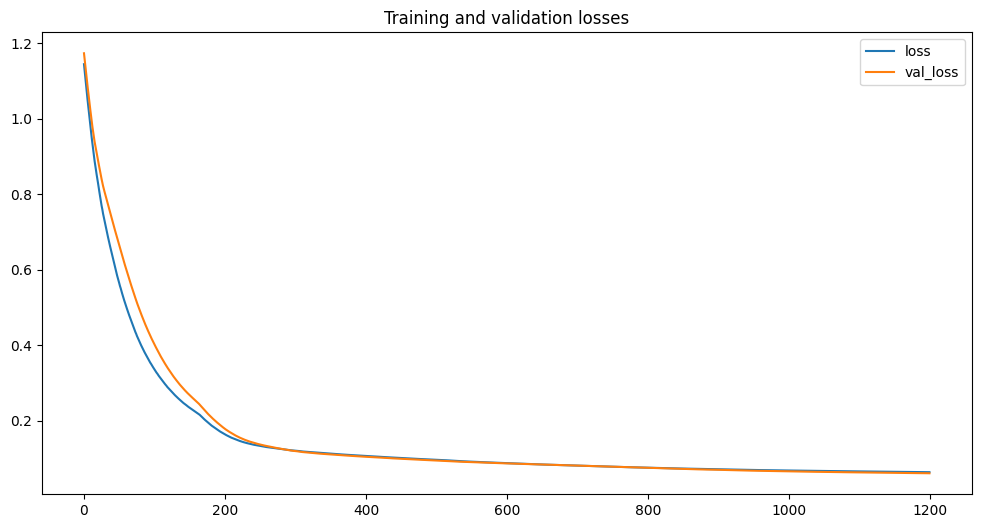

In [ ]:
# @title Training the Model

def create_FCNN_model():
  model = Sequential()
  model.add(InputLayer(input_shape = input_shape))
  model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0005)))
  model.add(Dense(16, kernel_regularizer=l2(0.0005), activation='relu'))
  model.add(Dense(output_shape, activation='linear'))

  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  return model

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/weights/cp.ckpt",
                                                  save_weights_only=True,
                                                  verbose=0)
losses_to_graph = LogLossesToGraph()
early_stop = EarlyStopOnLossThreshold(monitor='loss', threshold=early_stop_threshold, patience=5, verbose=1)

model = create_FCNN_model()
model.fit(X_train_scaled, y_train_scaled, epochs=training_epochs, batch_size=32, verbose=0,
          validation_data=(X_val_scaled, y_val_scaled),
          callbacks=[
            IntervalLogger(training_log_interval),
            losses_to_graph,
            early_stop,
            cp_callback,
        ])

losses_to_graph.show_losses()

## LSTM

In [ ]:
# @title Loading data for model

input_columns =  [
    'cpi_trend',
    'ppi_trend',
    'ipi_trend',
    'labour_employed_trend',
    'labour_unemployed_trend',
]
target_column = ['cpi_overall']

sequence_length = 6
target_forecast_months = [3, 6, 9, 12]
max_forecast_months = max(target_forecast_months)

X, y = data[input_columns], data[target_column]
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_total, y_total = [], []
for i in range(sequence_length, len(data) - max_forecast_months):
  X_total.append(tuple(X_scaled[i-sequence_length: i]))
  y_total.append([ y_scaled[i+j][0] for j in target_forecast_months ])
X_total = np.array(X_total)
y_total = np.array(y_total)

train_size = int(len(X_total) * train_ratio)
val_size = int(len(X_total) * val_ratio)
test_size = int(len(X_total) * test_ratio)

val_size_cum = train_size + val_size
test_size_cum = len(X_total)

print("Train : " + str(train_size))
print("Val : " + str(val_size) + ", cumulative : " + str(val_size_cum))
print("Test : " + str(test_size) + ", cumulative : " + str(test_size_cum))

# do this
X_train_total, y_train_total = X_total[: val_size_cum], y_total[: val_size_cum]
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=val_ratio, random_state=42)
X_test, y_test = X_total[val_size_cum:], y_total[val_size_cum:]

input_shape = (X_train.shape[1], )
output_shape = len(target_forecast_months)

print("Train X shape : " + str(X_train.shape))
print("Train Y shape : " + str(y_train.shape))
print("Val X shape : " + str(X_val.shape))
print("Val Y shape : " + str(y_val.shape))
print("Test X shape : " + str(X_test.shape))
print("Test Y shape : " + str(y_test.shape))

Train : 58
Val : 16, cumulative : 74
Test : 8, cumulative : 84
Train X shape : (59, 6, 5)
Train Y shape : (59, 4)
Val X shape : (15, 6, 5)
Val Y shape : (15, 4)
Test X shape : (10, 6, 5)
Test Y shape : (10, 4)


In [ ]:
# @title Model Parameters

training_epochs = 1250 # @param {type:"integer"}
training_log_interval = 25 # @param {type:"integer"}
early_stop_threshold = 0.01 # @param {type:"integer"} 0 = no early stopping.
learning_rate = 0.0001 # @param {type:"number"}

In [ ]:
# @title Training the Model

def create_LSTM_model():
  input_layers = [Input(shape=(sequence_length, 1), name=f'input_{i}') for i in range(len(input_columns))]
  lstm_layers = [LSTM(32, return_sequences=True)(input_layer) for input_layer in input_layers]

  concatenated_output = concatenate(lstm_layers, axis=-1)
  dense_layer = Dense(16, activation='relu')(concatenated_output)
  output_layer = Dense(output_shape, activation='linear')(dense_layer)

  model = Model(inputs=input_layers, outputs=output_layer)
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/weights/cp.ckpt",
                                                  save_weights_only=True,
                                                  verbose=0)
losses_to_graph = LogLossesToGraph()
early_stop = EarlyStopOnLossThreshold(monitor='loss', threshold=early_stop_threshold, patience=5, verbose=1)

model = create_LSTM_model()
model.fit(X_train, y_train, epochs=training_epochs, batch_size=32, verbose=0,
          validation_data=(X_val, y_val),
          callbacks=[
            IntervalLogger(training_log_interval),
            losses_to_graph,
            early_stop,
            cp_callback,
        ])

losses_to_graph.show_losses()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 6, 1)]               0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 6, 1)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6, 1)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 6, 1)]               0         []                            
                                                                                              

ValueError: ignored

# Model Evaluation

In [ ]:
model_save_name

'my_model_8476326651100'

In [ ]:
# @title Saving the model

import datetime

model_save_name = 'my_model_' + str(hash(model))

model.save(model_save_name + '.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                384       
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
Total params: 1492 (5.83 KB)
Trainable params: 1492 (5.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


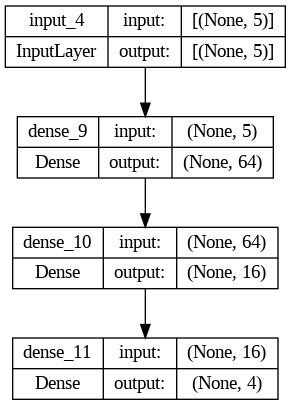

In [ ]:
# @title View Model

model = load_model("my_model_3_6_9_12.h5")
plot_model(model, show_shapes=True, show_layer_names=True)

3/3 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 1.8882
Mean Squared Error (MSE): 4.8051


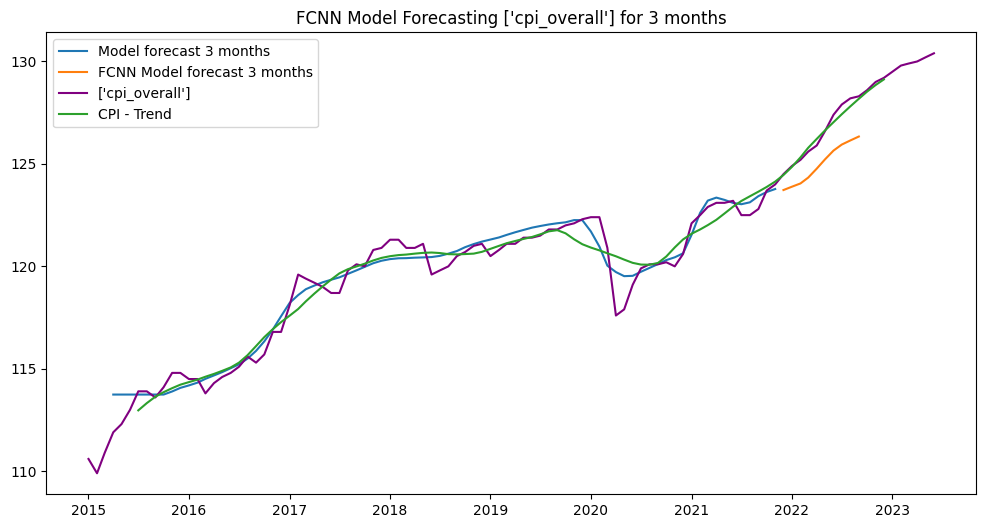

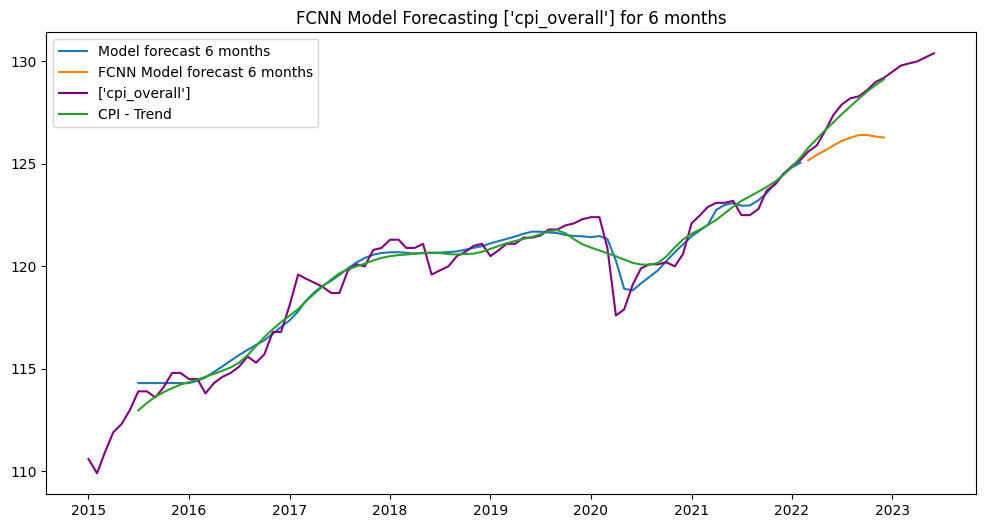

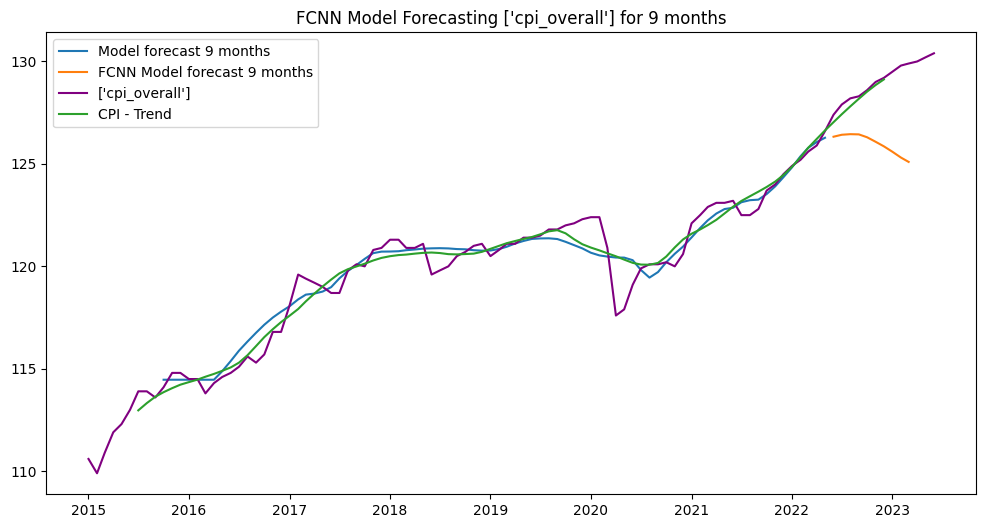

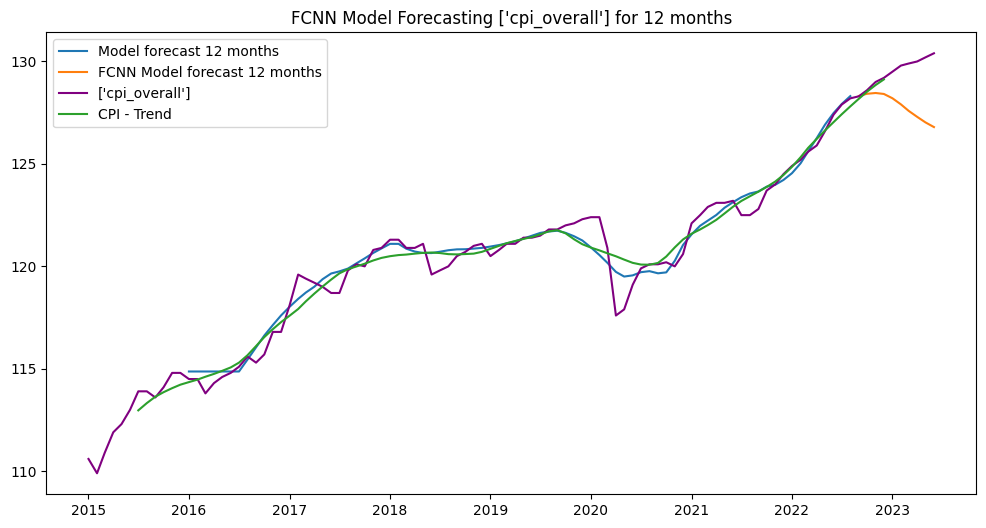

array([[123.72456 , 125.178795, 126.327255, 128.318   ],
       [123.88846 , 125.44141 , 126.42291 , 128.42348 ],
       [124.04786 , 125.654854, 126.45163 , 128.4616  ],
       [124.332504, 125.906494, 126.44113 , 128.41435 ],
       [124.769325, 126.12266 , 126.30035 , 128.20534 ],
       [125.22158 , 126.2729  , 126.08014 , 127.905464],
       [125.65103 , 126.407646, 125.857834, 127.59047 ],
       [125.94442 , 126.41314 , 125.59339 , 127.296974],
       [126.144455, 126.335785, 125.3102  , 127.02781 ],
       [126.336815, 126.29025 , 125.09754 , 126.79797 ]], dtype=float32)

In [ ]:
# @title View Model Output with Original Data
def view_model_output_with_known_data():
  # model = load_model(model_save_name + ".h5")
  # model = load_model("/content/my_model_3_6_9_12.h5")
  data = read_data()

  pred_test = model.predict(X_test_scaled)
  pred_test = scaler_y.inverse_transform(pred_test.reshape(-1, len(target_forecast_months)))

  pred_train = model.predict(X_train_total_scaled)
  pred_train = scaler_y.inverse_transform(pred_train.reshape(-1, len(target_forecast_months)))

  mae = mean_absolute_error(y_test, pred_test)
  print(f'Mean Absolute Error (MAE): {mae:.4f}')

  mse = mean_squared_error(y_test, pred_test)
  print(f'Mean Squared Error (MSE): {mse:.4f}')

  for i in range(len(target_forecast_months)):
    forecast_length = target_forecast_months[i]

    plt.figure(figsize=(12, 6))
    plt.title('FCNN Model Forecasting ' + str(target_column) + " for " + str(forecast_length) + " months")

    disjoint_time = [data.index[forecast_length: len(X_train_scaled) + forecast_length], data.index[len(X_train_scaled)+forecast_length: len(X)+forecast_length]]
    time_index_agg = pd.concat([pd.Series(x) for x in disjoint_time])

    plt.plot(data.index[forecast_length: len(pred_train) + forecast_length], pred_train[:, i], label='Model forecast ' + str(forecast_length) + " months")
    plt.plot(data.index[len(pred_train) + forecast_length: len(pred_train) + forecast_length + len(pred_test)], pred_test[:, i], label='FCNN Model forecast ' + str(forecast_length) + " months")

    plt.plot(data.index, data[target_column], color='purple', label=target_column)
    seasonal_decomposition = seasonal_decompose(data[target_column], model='additive', period=12)
    plt.plot(seasonal_decomposition.trend, label = "CPI - Trend")

    plt.legend()
    plt.show()

  return pred_test


view_model_output_with_known_data()

In [ ]:
# @title Forecast future CPI

selected_forecast_levels = [3]

def forecast_future_CPI(start_year:int, start_month:int, num_of_months:int):
  start_month = str(start_year) + "-" + str(start_month).rjust(2, "0")
  date_range = pd.date_range(start_month, freq='MS', periods=num_of_months)
  # date_range = create_date_range(start_year, start_month, num_of_months)

  data = read_data()
  model = load_model("my_model_3_6_9_12.h5")

  input_date = date_range[0]
  inputs = data.loc[input_date][input_columns]
  inputs_scaled = scaler_x.transform([ inputs.array, ])

  forecast_scaled = model.predict(inputs_scaled, verbose=0)
  forecast = scaler_y.inverse_transform(forecast_scaled)[0]

  cpi_over_time = []
  initial_val = data.loc[input_date][target_column].array[0]
  previous_start_val = initial_val
  previous_months_count = 0

  for i in range(0, len(selected_forecast_levels)):
    months_count = selected_forecast_levels[i] - previous_months_count
    forecast_val = forecast[i]

    monthly_increment = (forecast_val - previous_start_val) / months_count

    for j in range(months_count):
      cpi_over_time.append(previous_start_val + (monthly_increment * j))

    previous_start_val = forecast_val
    previous_months_count = selected_forecast_levels[i]

  if len(cpi_over_time) > num_of_months:
    cpi_over_time = cpi_over_time[:num_of_months]
  else:
    monthly_increment = (max(forecast) - initial_val) / len(cpi_over_time)
    for i in range(len(cpi_over_time), num_of_months):
      cpi_over_time.append(cpi_over_time[-1] + monthly_increment)

  previous_cpi = initial_val
  inflation_over_time = []
  for cpi in cpi_over_time:
    old_cpi = previous_cpi
    new_cpi = cpi

    inflation = ((new_cpi - old_cpi) / old_cpi) * 100
    inflation_over_time.append(inflation)

    previous_cpi = new_cpi

  return inflation_over_time

In [ ]:
# @title Exported Script
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, InputLayer, concatenate, Input, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

def read_gov_data(URL_LINK):
  df = pd.read_parquet(URL_LINK)
  if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

  return df

def find_date_range(datasets):
    # Ensure that all datasets have a datetime index
    for df in datasets:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("All datasets must have a datetime index.")

    # Find the maximum start date
    max_start_date = max(df.index.min() for df in datasets)

    # Find the minimum end date
    min_end_date = min(df.index.max() for df in datasets)

    return max_start_date, min_end_date

URL_ECON_INDICATOR = 'https://storage.dosm.gov.my/econindicators/economic_indicators.parquet'
URL_CPI = 'https://storage.dosm.gov.my/cpi/cpi_headline.parquet'
URL_IPI = 'https://storage.dosm.gov.my/ipi/ipi.parquet'
URL_PPI = 'https://storage.dosm.gov.my/ppi/ppi.parquet'
URL_LABOUR = 'https://storage.dosm.gov.my/labour/labourforce_monthly.parquet'

econ_indicator_df = read_gov_data(URL_ECON_INDICATOR)
cpi_df = read_gov_data(URL_CPI)
ipi_df = read_gov_data(URL_IPI)
ppi_df = read_gov_data(URL_PPI)
lfs_df = read_gov_data(URL_LABOUR)

start_date, end_date = find_date_range([econ_indicator_df, cpi_df, ppi_df, ipi_df])

def get_col_from(df, column):
  return df[column][(df.index >= start_date) & (df.index <= end_date)]

def read_data():
  data = pd.DataFrame()
  data["cpi_overall"] = get_col_from(cpi_df, "overall")

  data["ipi_overall"] = get_col_from(ipi_df, "overall")
  data["ipi_mfg"] = get_col_from(ipi_df, "mfg")
  data["ipi_elec"] = get_col_from(ipi_df, "electric")

  data["ppi_agri"] = get_col_from(ppi_df, "agriculture")
  data["ppi_mining"] = get_col_from(ppi_df, "mining")
  data["ppi_mfg"] = get_col_from(ppi_df, "manufacturing")
  data["ppi_elec"] = get_col_from(ppi_df, "electricity")
  data["ppi_water"] = get_col_from(ppi_df, "water")
  data["ppi_overall"] = get_col_from(ppi_df, "overall")

  data["labour_unemployed"] = get_col_from(lfs_df, "unemployed")
  data["labour_employed"] = get_col_from(lfs_df, "employed")


  data["cpi_trend"] = seasonal_decompose(data["cpi_overall"], model='additive', period=12).trend
  data['cpi_trend'].fillna(method='ffill', inplace=True)
  data['cpi_trend'].fillna(method='bfill', inplace=True)

  data["ipi_trend"] = seasonal_decompose(data["ipi_overall"], model='additive', period=12).trend
  data['ipi_trend'].fillna(method='ffill', inplace=True)
  data['ipi_trend'].fillna(method='bfill', inplace=True)

  data["ppi_trend"] = seasonal_decompose(data["ppi_overall"], model='additive', period=12).trend
  data['ppi_trend'].fillna(method='ffill', inplace=True)
  data['ppi_trend'].fillna(method='bfill', inplace=True)

  data["labour_unemployed_trend"] = seasonal_decompose(data["labour_unemployed"], model='additive', period=12).trend
  data['labour_unemployed_trend'].fillna(method='ffill', inplace=True)
  data['labour_unemployed_trend'].fillna(method='bfill', inplace=True)

  data["labour_employed_trend"] = seasonal_decompose(data["labour_employed"], model='additive', period=12).trend
  data['labour_employed_trend'].fillna(method='ffill', inplace=True)
  data['labour_employed_trend'].fillna(method='bfill', inplace=True)
  return data

data = read_data()

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
# @title Loading data for model

# input_columns =  [
#     'cpi_overall',
#     'ppi_overall',
#     'ipi_overall',
#     'labour_employed',
#     'labour_unemployed',
# ]
input_columns =  [
    'cpi_trend',
    'ppi_trend',
    'ipi_trend',
    'labour_employed_trend',
    'labour_unemployed_trend',
]
target_column = ['cpi_overall']
target_forecast_months = [3, 6, 9, 12]
max_forecast_months = max(target_forecast_months)

X, y = [], []
for i in range(len(data) - max_forecast_months):
  X.append(data[input_columns].iloc[i])
  y.append([ data[target_column].iloc[i+j][0] for j in target_forecast_months ])
X = np.array(X)
y = np.array(y)

train_size = int(len(X) * train_ratio)
val_size = int(len(X) * val_ratio)
test_size = int(len(X) * test_ratio)

val_size_cum = train_size + val_size
test_size_cum = len(X)

print("Train : " + str(train_size))
print("Val : " + str(val_size) + ", cumulative : " + str(val_size_cum))
print("Test : " + str(test_size) + ", cumulative : " + str(test_size_cum))

X_train_total, y_train_total = X[: val_size_cum], y[: val_size_cum]
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=val_ratio, random_state=42)
X_test, y_test = X[val_size_cum:], y[val_size_cum:]

scaler_x = StandardScaler()
X_train_total_scaled = scaler_x.fit_transform(X_train_total)
X_train_scaled = scaler_x.fit_transform(X_train)
X_val_scaled = scaler_x.transform(X_val)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()

y_train_total_scaled = scaler_y.fit_transform(y_train_total)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

input_shape = (X_train_scaled.shape[1], )
output_shape = len(target_forecast_months)

print("Train X shape : " + str(X_train_scaled.shape))
print("Train Y shape : " + str(y_train_scaled.shape))
print("Val X shape : " + str(X_val_scaled.shape))
print("Val Y shape : " + str(y_val_scaled.shape))
print("Test X shape : " + str(X_test_scaled.shape))
print("Test Y shape : " + str(y_test_scaled.shape))

model = load_model("my_model_3_6_9_12.h5")

selected_forecast_levels = [3]

def forecast_future_CPI(start_year:int, start_month:int, num_of_months:int):
  start_month = str(start_year) + "-" + str(start_month).rjust(2, "0")
  date_range = pd.date_range(start_month, freq='MS', periods=num_of_months)
  # date_range = create_date_range(start_year, start_month, num_of_months)

  data = read_data()
  model = load_model("my_model_3_6_9_12.h5")

  input_date = date_range[0]
  inputs = data.loc[input_date][input_columns]
  inputs_scaled = scaler_x.transform([ inputs.array, ])

  forecast_scaled = model.predict(inputs_scaled, verbose=0)
  forecast = scaler_y.inverse_transform(forecast_scaled)[0]

  cpi_over_time = []
  initial_val = data.loc[input_date][target_column].array[0]
  previous_start_val = initial_val
  previous_months_count = 0

  for i in range(0, len(selected_forecast_levels)):
    months_count = selected_forecast_levels[i] - previous_months_count
    forecast_val = forecast[i]

    monthly_increment = (forecast_val - previous_start_val) / months_count

    for j in range(months_count):
      cpi_over_time.append(previous_start_val + (monthly_increment * j))

    previous_start_val = forecast_val
    previous_months_count = selected_forecast_levels[i]

  if len(cpi_over_time) > num_of_months:
    cpi_over_time = cpi_over_time[:num_of_months]
  else:
    monthly_increment = (max(forecast) - initial_val) / len(cpi_over_time)
    for i in range(len(cpi_over_time), num_of_months):
      cpi_over_time.append(cpi_over_time[-1] + monthly_increment)

  previous_cpi = initial_val
  inflation_over_time = []
  for cpi in cpi_over_time:
    old_cpi = previous_cpi
    new_cpi = cpi

    inflation = ((new_cpi - old_cpi) / old_cpi) * 100
    inflation_over_time.append(inflation)

    previous_cpi = new_cpi

  return inflation_over_time

Train : 54
Val : 18, cumulative : 72
Test : 18, cumulative : 90
Train X shape : (57, 5)
Train Y shape : (57, 4)
Val X shape : (15, 5)
Val Y shape : (15, 4)
Test X shape : (18, 5)
Test Y shape : (18, 4)


In [ ]:
forecast_future_CPI(2023, 3, 120)

[0.0,
 0.12706495230705436,
 0.12690370217842734,
 0.12674286079580876,
 0.1265824266070622,
 0.12642239806781314,
 0.12626277364150862,
 0.1261035517993463,
 0.12594473102022566,
 0.1257863097906995,
 0.12562828660492587,
 0.12547065996462042,
 0.125313428379009,
 0.1251565903647806,
 0.1250001444460409,
 0.12484408915426572,
 0.12468842302825528,
 0.12453314461408847,
 0.12437825246507768,
 0.12422374514172371,
 0.12406962121167142,
 0.12391587924966525,
 0.12376251783750539,
 0.12360953556400413,
 0.12345693102494262,
 0.1233047028230279,
 0.12315284956785016,
 0.12300136987584058,
 0.12285026237022913,
 0.122699525681003,
 0.12254915844486507,
 0.12239915930519296,
 0.12224952691199811,
 0.12210025992188528,
 0.12195135699801245,
 0.12180281681005078,
 0.12165463803414513,
 0.12150681935287459,
 0.12135935945521353,
 0.12121225703649284,
 0.12106551079836139,
 0.12091911944874788,
 0.12077308170182291,
 0.12062739627796135,
 0.12048206190370492,
 0.12033707731172508,
 0.12019244124